In [1]:
import gpytorch
import torch
import math
import pyro
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%pdb

Automatic pdb calling has been turned ON


## Introduction

In this notebook, we demonstrate how to implement and use functional kernel learning (http://papers.nips.cc/paper/9634-function-space-distributions-over-kernels) with variational inference in Pyro and Gpytorch.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes or FKL, but rather how to train a simple model and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf . See also the full paper and https://github.com/wjmaddox/spectralgp for a MCMC implementation (as in the paper).

Functional kernel learning uses two Gaussian process models, one over the logarithm of the spectral density in kernel space:
    
$$
f \sim GP(\mu(\omega), K(\omega))
$$

We then numerically compute the trapezoid rule integral of $K(\tau) = \int \cos{(2 \pi \tau \omega)} \exp\{f(\omega)\} d\omega $ to produce the kernel for the data space Gaussian process,
$$
g \sim GP(0, K(\tau)),
$$
so that the likelihood for the response, $y,$ becomes $y \sim N(g, \sigma^2 I).$

We first define the data space Gaussian process using PyroGP and our SpectralGPKernel.

In [2]:
class SpectralGPModel(gpytorch.models.PyroGP):
    def __init__(self, train_x, train_y, likelihood, inner_gp, **kwargs):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_y.numel(),
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )

        # Standard initializtation
        super(SpectralGPModel, self).__init__(
            variational_strategy,
            likelihood,
            num_data=train_y.numel(),
            name_prefix="fkl_regression_model"
        )
        self.likelihood = likelihood

        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralGPKernel(train_inputs=train_x, **kwargs)
        self.omega = self.covar_module.omega

        self.inner_gp = inner_gp

    def forward(self, x_input):
        function_samples = self.inner_gp.model(self.omega)
        self.covar_module.set_latent_params(function_samples)

        mean = self.mean_module(x_input)  # Returns an n_data vec
        covar = self.covar_module(x_input)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    # def model(self, x, y):
    #     inner_gp_samples = self.inner_gp.model(self.omega)
    #     return super().model(x, y, inner_gp_samples)

    # def guide(self, x, y):
    #     inner_gp_samples = self.inner_gp.model(self.omega)
    #     return super().model(x, y, inner_gp_samples)




Next, we define our inner Gaussian process model on the latent GP. 
We place a negative quadratic mean on the mean of the distribution and a Matern 1.5 kernel to enforce some smoothness consstraints.

In [3]:

class InnerGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_data, omega=None, num_inducing=64, name_prefix="inner_gp"):
        self.num_data = num_data
        self.name_prefix = name_prefix

        # Define all the variational stuff
        if omega is None:
            inducing_points = torch.linspace(0, 1, num_inducing)
        else:
            inducing_points = torch.arange(omega.min(), omega.max(), num_inducing)

        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points,
            gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        )

        # Standard initializtation
        super().__init__(variational_strategy)

        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.QuadraticMean(input_size = 1, 
                        raw_quadratic_weights_constraint=gpytorch.constraints.LessThan(0.0),
                        raw_bias_constraint=gpytorch.constraints.Positive(), use_weights=False)
        self.mean_module.quadratic_weights = -10.
        self.mean_module.bias = 5.

        self.covar_module = gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.MaternKernel(nu=1.5, 
                            lengthscale_prior=gpytorch.priors.NormalPrior(torch.zeros(1), 
                                    torch.ones(1), transform=torch.exp)),
                            outputscale_prior=gpytorch.priors.NormalPrior(torch.zeros(1), 
                                    torch.ones(1), transform=torch.exp),
                        )
        
    def forward(self, x):
        # compute prior gp mean and covariance
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, x):
        # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            pyro.sample(self.name_prefix + ".f(x)", function_dist)

    def model(self, x):
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            function_samples = pyro.sample(self.name_prefix + ".f(x)", function_dist)

        return function_samples

We generate data following the sinc problem first described in Wilson et al, 2014.

In [4]:
def generate_data(nx=200, split=150):
    full_x = torch.linspace(-15., 15., nx)#.cuda()

    sinc = lambda x: torch.sin(math.pi * x) / (math.pi * x)
    sinc_testfn = lambda x: sinc(x) + sinc(x - 10.) + sinc(x + 10.)

    full_y = sinc_testfn(full_x)

    train_set = ~((full_x > -4.5) * (full_x < 4.5))
    train_x = full_x[train_set]
    train_y = full_y[train_set]

    test_x = full_x[~train_set]
    test_y = full_y[~train_set]

    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = generate_data()



Defining the model classes.

In [5]:
inner_model = InnerGPModel(num_data=len(train_x))
outer_lh = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralGPModel(train_x, train_y, outer_lh, inner_gp=inner_model,
                        register_latent_params=False)

model.train();



Now we run inference.

In [6]:
# this is for running the notebook in our testing framework
num_iter =  2000
num_particles = 1

def train():
    optimizer = pyro.optim.Adam({"lr": 1e-3})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

    model.train()
    iterator = tqdm.tqdm_notebook(range(num_iter))
    for i in iterator:
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        iterator.set_postfix(loss=loss, lengthscale=model.inner_gp.covar_module.base_kernel.lengthscale.item())

train()

In [7]:
model.eval();

We show the predictions in data space.

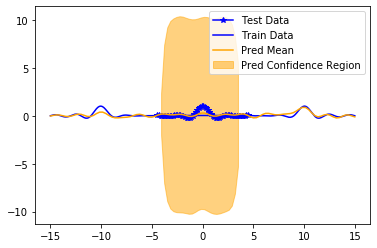

In [11]:
full_x = torch.linspace(-15., 15)
pred_dist = model(full_x)
conf_region = pred_dist.confidence_region()
pred_mean = pred_dist.mean.data

plt.plot(test_x, test_y, marker='*', label = 'Test Data', color = 'blue')
plt.plot(train_x, train_y, label = 'Train Data', color = 'blue')
plt.plot(full_x, pred_mean, label = 'Pred Mean', color = 'orange')
plt.fill_between(full_x, conf_region[0].data, conf_region[1].data, color = 'orange',
                alpha = 0.5, label = 'Pred Confidence Region')
plt.legend()

as well as the posterior in spectral space.

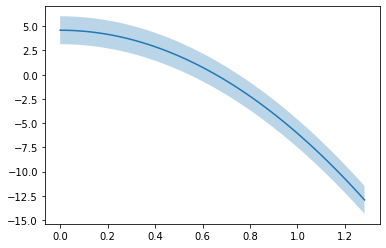

In [12]:
with torch.no_grad():
    spectral_dist = model.inner_gp(model.omega)
plt.plot(model.omega, spectral_dist.mean)
plt.fill_between(model.omega, *spectral_dist.confidence_region(), alpha = 0.3)